In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

/Users/ronbonner/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_data_and_metadata(file_name, index_col=None):
    hash_counter = 0
    meta_dict = {}
    for line in open(file_name):
        if line[0] is not '#': break
        hash_counter +=1
        fields = line[1:-2].split(';')
        for field in fields:
            parts = field.split(':')
            meta_dict[parts[0]] = parts[1]
    data = pd.read_csv(file_name,skiprows=hash_counter, index_col=index_col)
    return data, meta_dict

In [3]:
"""
Assigns a column of numbers to buckets depending on how far apart they are
Input:
  data : pandas DataFrame
  column : the column to work on
  min_cnt (optional) : the minimum number a bucket must have to be retained
  max_delta : the maximum allowed difference between adjacent values; more than this starts a new bucket
Returns:
  sum_all : the number of values processed
  sum_kept : the total number in retained buckets
  results : a dict where key = average value in bucket, value = [indices of included rows]
  
"""
def bucket_vals(data, column, min_cnt=2, max_delta=0.01):
    last_val=0.0       #prvious values for comparison
    val_sum=0          #sum the values assigned to a bucket so we can calculate the average
    results = {}       # dict - (average value, count, indices of the values assigned to the bucket)
    thisList = []
    sum_all=0
    sum_kept=0
    temp = data.sort_values(by=column)   #sort values in order
    for i in range(len(data)):
        sum_all += 1
        val = temp.ix[i, column]
        if val - last_val > max_delta:
            if len(thisList) >= min_cnt:
                sum_kept += len(thisList)
                ave = round(val_sum / float(len(thisList)), 5)
                results[ave] = thisList
            thisList=[temp.index[i]]
            val_sum = val
        else:
            thisList.append(temp.index[i])
            val_sum += val
        last_val = val
    #
    # write te last value, if there is one
    if len(thisList) >= min_cnt:
        sum_kept += len(thisList)
        ave = round(val_sum / float(len(thisList)), 5)
        results[ave] = thisList

    #
    return sum_all, sum_kept, results

In [4]:
"""
Takes a dictionary of buckets (key = average mz, value = [indices]) and generates a single string with the
entires sorted in descending length of [indices] and formatted as key: list len separated by \n
"""
def buckets_as_string(d, min_cnt):
    return '\n'.join(["{:12.5f} : {:3.0f}".format(k, len(d[k]))
                      for k in sorted(d, key=lambda k: len(d[k]), reverse=True) if len(d[k]) >= min_cnt])

In [5]:
def fill_smvdict(sd, grps, offset):
    for mbar,smvlist in grps.iteritems():
        for smv in smvlist:
            sd[smv][offset] = mbar

In [6]:
def add_bucket_desc(ax, d, min_cnt):
    t = buckets_as_string(d, min_cnt)
    ax.text(0.95, 0.95, t, verticalalignment='top', horizontalalignment='right',transform=ax.transAxes)


In [7]:
def smv_dict_value_list(smv, smv_comps, pos_data, neg_data):
    result = [smv_comps.Name[smv], smv_comps.SMILES[smv], smv_comps.Formula[smv], smv_comps.Exact_mass[smv]]
    if smv in pos_data.index:
        t = [pos_data.Base_peak_mz[smv], pos_data.Base_peak_inten[smv], pos_data.BPI_fract_TIC[smv],None, None]
    else:
        t = [None, None, None, None, None]
    result += t
    #
    if smv in neg_data.index:
        t = [neg_data.Base_peak_mz[smv], neg_data.Base_peak_inten[smv], neg_data.BPI_fract_TIC[smv],None, None]
    else:
        t = [None, None, None, None, None]
    result += t
    #
    return result
    

In [8]:
smv_path = "/Users/ronbonner/python_notebooks/SMV_Data/"
pos_file = smv_path + "170321 SMV pos combined summary.csv"
neg_file = smv_path + "170321 SMV neg combined summary.csv"


In [9]:
# Read the SMV master compound file so we can retrieve meta data (Smiles, MW, etc.)
smv_compound_file = smv_path + "SMV Master compound list.csv"
smv_comps = pd.read_csv(smv_compound_file)
smv_comps.set_index(keys=smv_comps.columns[0], inplace=True)   #Simply using "Accession" doesn't work?
l = len(smv_comps)
smv_comps.dropna(subset=['Exact_mass'], inplace=True)
print 'Original',l, ', after dropping Nans', len(smv_comps)

Original 775 , after dropping Nans 767


In [10]:
do_write = False
# For finally writing to a pdf file - all figs in this list will be written
if do_write:
    figs=[]

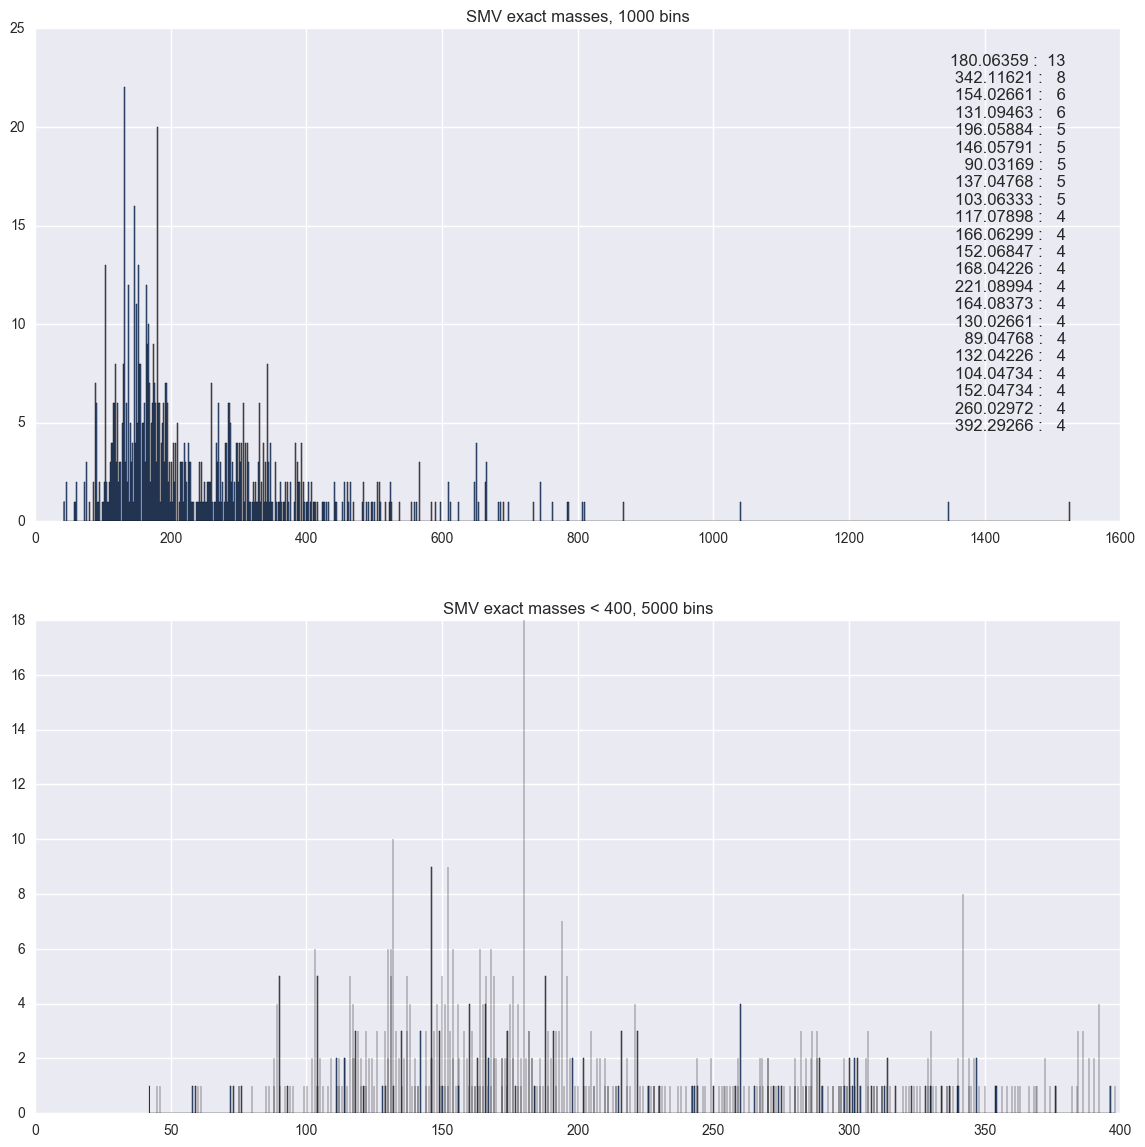

In [68]:
mw_buckets = bucket_vals(smv_comps, 'Exact_mass', min_cnt=3, max_delta=0.0025)
f, axs = plt.subplots(2, 1, figsize=(14,14))
axs[0].hist(smv_comps.Exact_mass, bins=1000);
axs[0].set_title('SMV exact masses, 1000 bins')
axs[1].hist(smv_comps.Exact_mass[smv_comps.Exact_mass < 400], bins=5000);
axs[1].set_title('SMV exact masses < 400, 5000 bins')
add_bucket_desc(axs[0], mw_buckets[2], 4)
if do_write: figs.append(f)

In [12]:
pos_data, meta_data = get_data_and_metadata(pos_file, index_col='SMV')
neg_data, meta_data = get_data_and_metadata(neg_file, index_col='SMV')
#
# The following produce tuples of (num kept, num processed, [indices]) where kept means that the bucket contains
# at least the minimum count value
#
min_cnt = 3
pos_base_mz = bucket_vals(pos_data, 'Base_peak_mz', min_cnt=min_cnt)
print 'Pos base peak mz buckets: Kept', pos_base_mz[1],'out of', pos_base_mz[0]
pos_base_delta = bucket_vals(pos_data, 'Base_peak_delta', min_cnt=min_cnt)
print 'Pos base peak delta buckets: Kept', pos_base_delta[1],'out of', pos_base_delta[0]
neg_base_mz = bucket_vals(neg_data, 'Base_peak_mz', min_cnt=min_cnt)
print 'Neg base peak mz buckets: Kept', neg_base_mz[1],'out of', neg_base_mz[0]
neg_base_delta = bucket_vals(neg_data, 'Base_peak_delta', min_cnt=min_cnt)
print 'Neg base peak delta buckets: Kept', neg_base_delta[1],'out of', neg_base_delta[0]

Pos base peak mz buckets: Kept 210 out of 636
Pos base peak delta buckets: Kept 465 out of 636
Neg base peak mz buckets: Kept 248 out of 636
Neg base peak delta buckets: Kept 431 out of 636


In [67]:
# Explore some properties of the various delta groups....
# pos_base_delta[2] is the dictionary key=mass group, value = [SMV codes]
for m, inxs in pos_base_delta[2].iteritems():
    for inx in inxs:
        print m, inx, smv_comps.Exact_mass[inx], pos_data.Base_peak_mz[inx] - smv_comps.Exact_mass[inx],
            pos_data.BPI_fract_TIC[inx]

1.00621 SMV00666 320.011933 1.003167 0.237
1.00621 SMV00094 733.562155 1.003245 0.086
1.00621 SMV00574 432.86718 1.00322 0.566
1.00621 SMV00667 496.044021 1.003379 0.114
1.00621 SMV00225 376.138284 1.003916 0.336
1.00621 SMV00017 650.790038 1.003962 0.581
1.00621 SMV00028 598.279135 1.003865 0.13
1.00621 SMV00634 442.381081 1.003919 0.254
1.00621 SMV00519 488.107331 1.004469 0.491
1.00621 SMV00653 398.06849 1.00471 0.363
1.00621 SMV00027 347.063084 1.004716 0.156
1.00621 SMV00664 312.140867 1.004833 0.74
1.00621 SMV00031 290.122634 1.004766 0.301
1.00621 SMV00252 280.105922 1.004878 0.356
1.00621 SMV00518 610.18977 1.00493 0.294
1.00621 SMV00344 300.20893 1.00497 0.418
1.00621 SMV00503 324.035867 1.005033 0.18
1.00621 SMV00117 312.20893 1.00507 0.368
1.00621 SMV00573 270.052823 1.004977 0.591
1.00621 SMV00378 361.143784 1.004916 0.707
1.00621 SMV00223 307.083806 1.004994 0.361
1.00621 SMV00382 348.0471 1.005 0.135
1.00621 SMV00686 314.22458 1.00512 0.681
1.00621 SMV00023 330.219495 1.0

1.00621 250


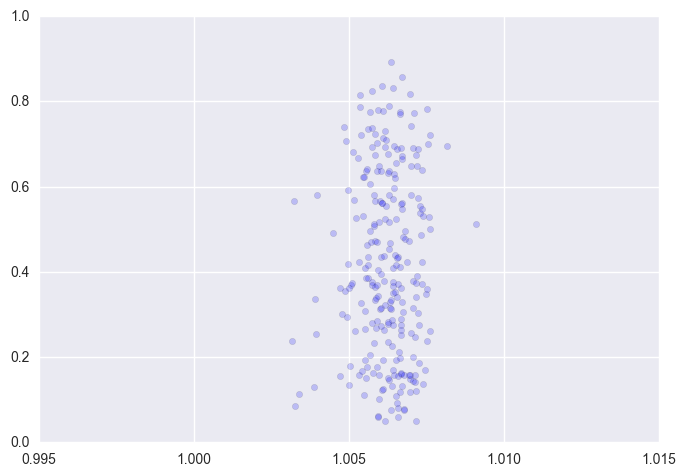

In [66]:
gDict = pos_base_delta[2]
k1 = gDict.keys()[0]
inxs = gDict[k1]
print k1, len(inxs)
dels = [pos_data.Base_peak_mz[inx] - smv_comps.Exact_mass[inx] for inx in inxs]
intens = [pos_data.BPI_fract_TIC[inx] for inx in inxs]
plt.scatter(x=dels, y=intens, alpha=0.2)

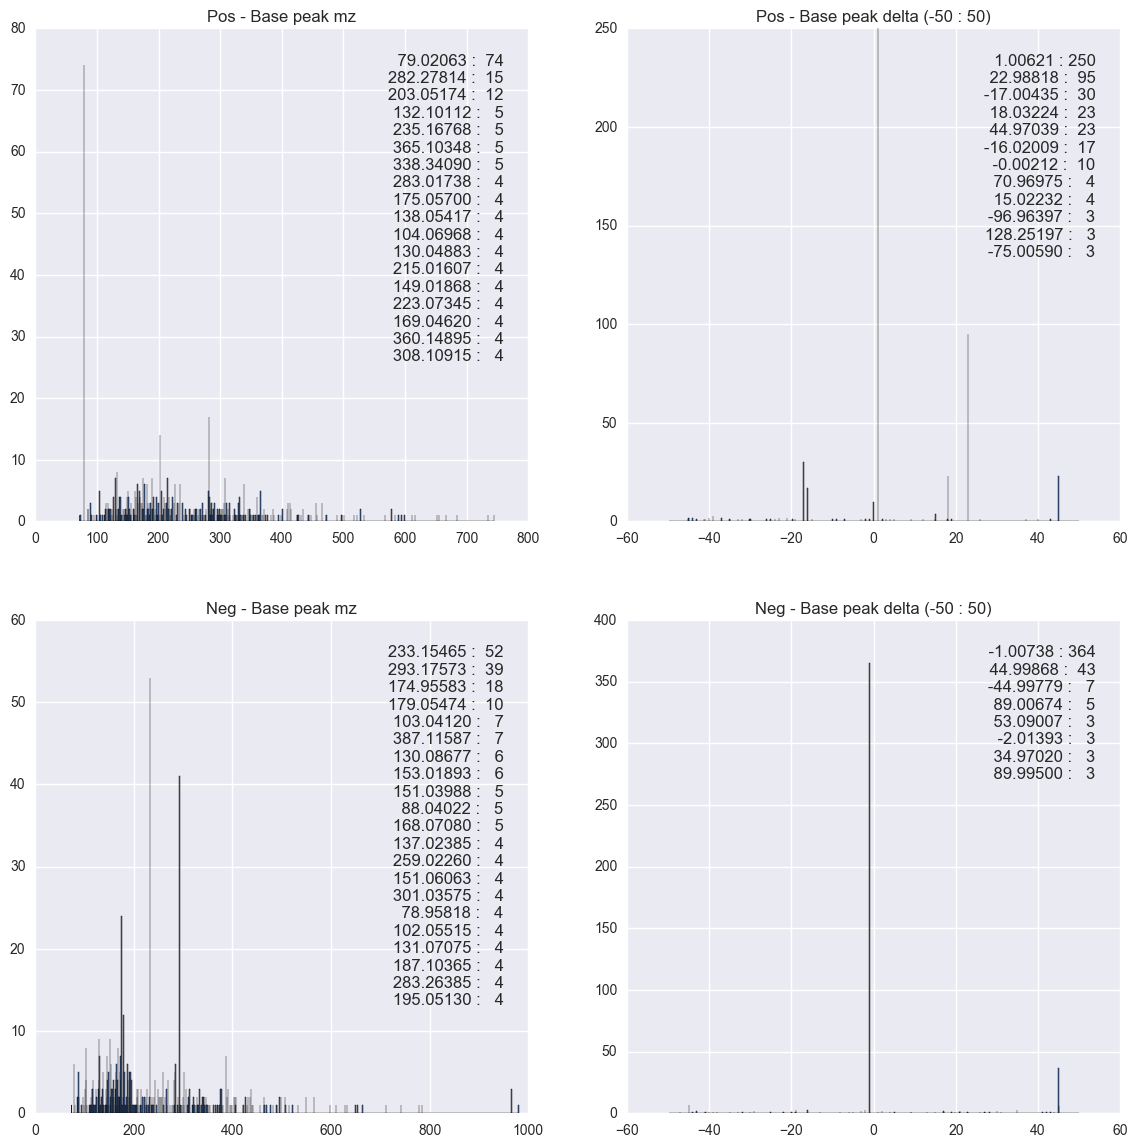

In [13]:
f, axs = plt.subplots(2, 2, figsize=(14,14))
#
axs[0, 0].hist(pos_data['Base_peak_mz'], bins=1000)
axs[0, 0].set_title('Pos - Base peak mz')
add_bucket_desc(axs[0,0], pos_base_mz[2], 4)
#
axs[0, 1].hist(pos_data['Base_peak_delta'], bins=1000, range=(-50,50))
axs[0, 1].set_title('Pos - Base peak delta (-50 : 50)')
add_bucket_desc(axs[0,1], pos_base_delta[2], 3)
#
axs[1, 0].hist(neg_data['Base_peak_mz'], bins=1000)
axs[1, 0].set_title('Neg - Base peak mz')
add_bucket_desc(axs[1,0], neg_base_mz[2], 4)
#
axs[1, 1].hist(neg_data['Base_peak_delta'], bins=1000, range=(-50,50))
axs[1, 1].set_title('Neg - Base peak delta (-50 : 50)')
add_bucket_desc(axs[1,1], neg_base_delta[2], 3)
if do_write: figs.append(f)

In [14]:
smvdict={smv:smv_dict_value_list(smv, smv_comps, pos_data, neg_data) for smv in pos_data.index}
for smv in neg_data.index:
    if not smvdict.has_key(smv):
        smvdict[smv]=smv_dict_value_list(smv, smv_comps, pos_data, neg_data)
print len(smvdict)

639


In [15]:
pos_base, pos_delta, neg_base, neg_delta = 7, 8, 12, 13
fill_smvdict(smvdict, pos_base_mz[2], pos_base)
fill_smvdict(smvdict, pos_base_delta[2], pos_delta)
fill_smvdict(smvdict, neg_base_mz[2], neg_base)
fill_smvdict(smvdict, neg_base_delta[2], neg_delta)

In [16]:
gdf = pd.DataFrame.from_dict(smvdict,orient='index')
gdf.columns=['Name', 'SMILES','Formula', 'MW',
             'Base_mz_pos','Base_inten_pos', 'Base_fract_TIC_pos','Base_mz_grp_pos', 'Base_delta_grp_pos',
             'Base_mz_neg','Base_inten_neg', 'Base_fract_TIC_neg','Base_mz_grp_neg', 'Base_delta_grp_neg']
#
gdf.Base_delta_grp_pos.fillna('None', inplace=True)
gdf.Base_delta_grp_neg.fillna('None', inplace=True)
gdf.Base_mz_grp_pos.fillna('None', inplace=True)
gdf.Base_mz_grp_neg.fillna('None', inplace=True)
gdf.head(5)

,Name,SMILES,Formula,MW,Base_mz_pos,Base_inten_pos,Base_fract_TIC_pos,Base_mz_grp_pos,Base_delta_grp_pos,Base_mz_neg,Base_inten_neg,Base_fract_TIC_neg,Base_mz_grp_neg,Base_delta_grp_neg
SMV00583,D-Glutamine,N[C@H](CCC(N)=O)C(O)=O,C5H10N2O3,146.069142,130.0490,20150.6,0.120,130.049,-16.0201,145.0612,40950.8,0.307,None,-1.00738
SMV00582,Benzocaine,CCOC(=O)C1=CC=C(N)C=C1,C9H11NO2,165.078979,166.0863,253864.6,0.487,166.086,1.00621,966.0029,4045.9,0.121,966.001,None
SMV00228,L-Histidine,N[C@@H](CC1=CNC=N1)C(O)=O,C6H9N3O2,155.069477,156.0752,57624.2,0.377,None,1.00621,154.0630,33474.0,0.266,None,-1.00738
SMV00229,Sebacic acid,OC(=O)CCCCCCCCC(O)=O,C10H18O4,202.120509,225.1080,116888.4,0.224,None,22.9882,201.1152,306135.3,0.603,None,-1.00738
SMV00587,Theobromine,CN1C=NC2=C1C(=O)NC(=O)N2C,C7H8N4O2,180.064726,181.0721,167172.4,0.530,None,1.00621,233.1537,1530.3,0.073,233.155,53.0901


In [17]:
if do_write: gdf.to_csv('/Users/ronbonner/python_notebooks/SMV_Data/combined group summary.csv')

In [18]:
amap=sns.light_palette('blue', 6, as_cmap=True)

In [19]:
def tabulate_and_plot(x, y):
    p = pd.crosstab(x, y, margins=True)
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(ax=ax, data=p, annot=True, fmt='d', linewidths=2, cmap=amap, cbar=False, mask=(p==0), annot_kws={"size": 10})
    plt.yticks(rotation=0)
    return f

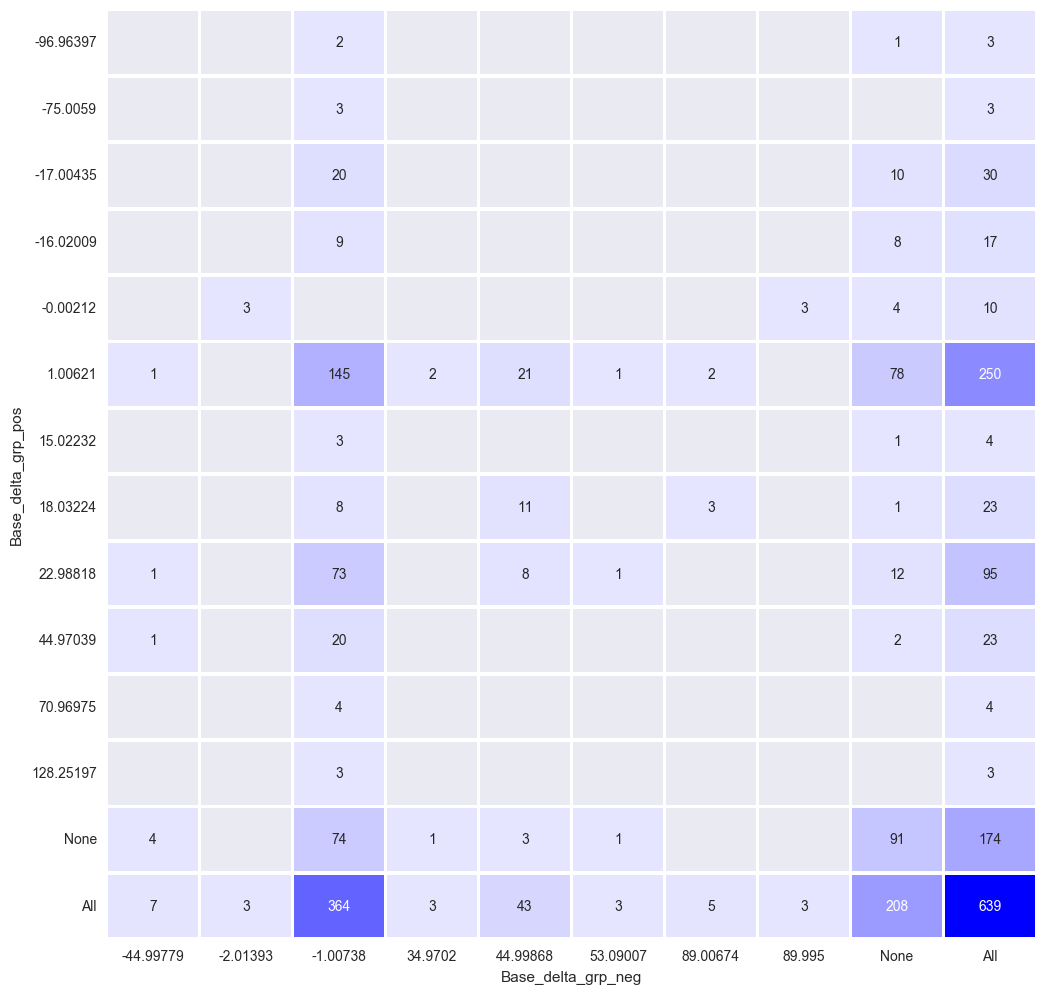

In [20]:
f = tabulate_and_plot(gdf.Base_delta_grp_pos, gdf.Base_delta_grp_neg)
if do_write: figs.append(f)

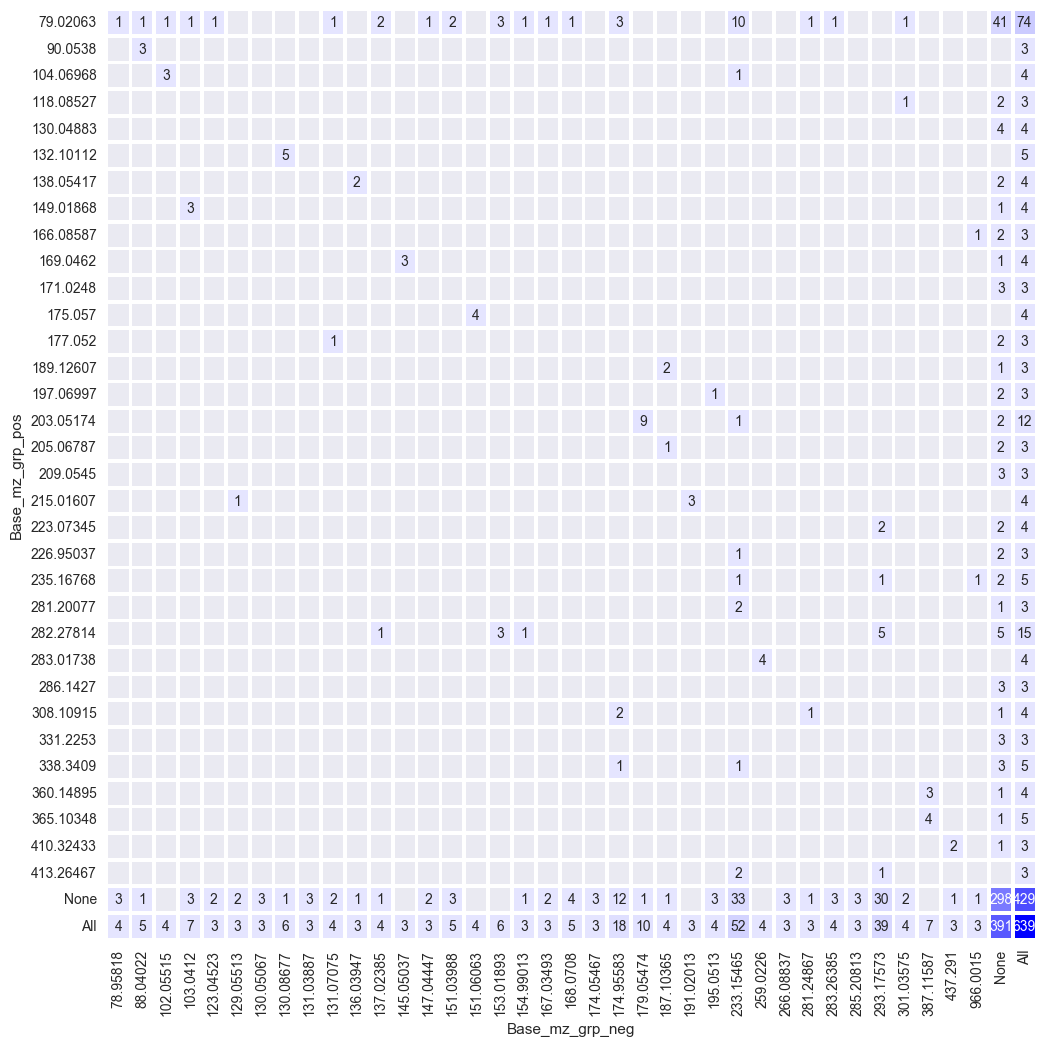

In [21]:
f = tabulate_and_plot(gdf.Base_mz_grp_pos, gdf.Base_mz_grp_neg)
if do_write:figs.append(f)

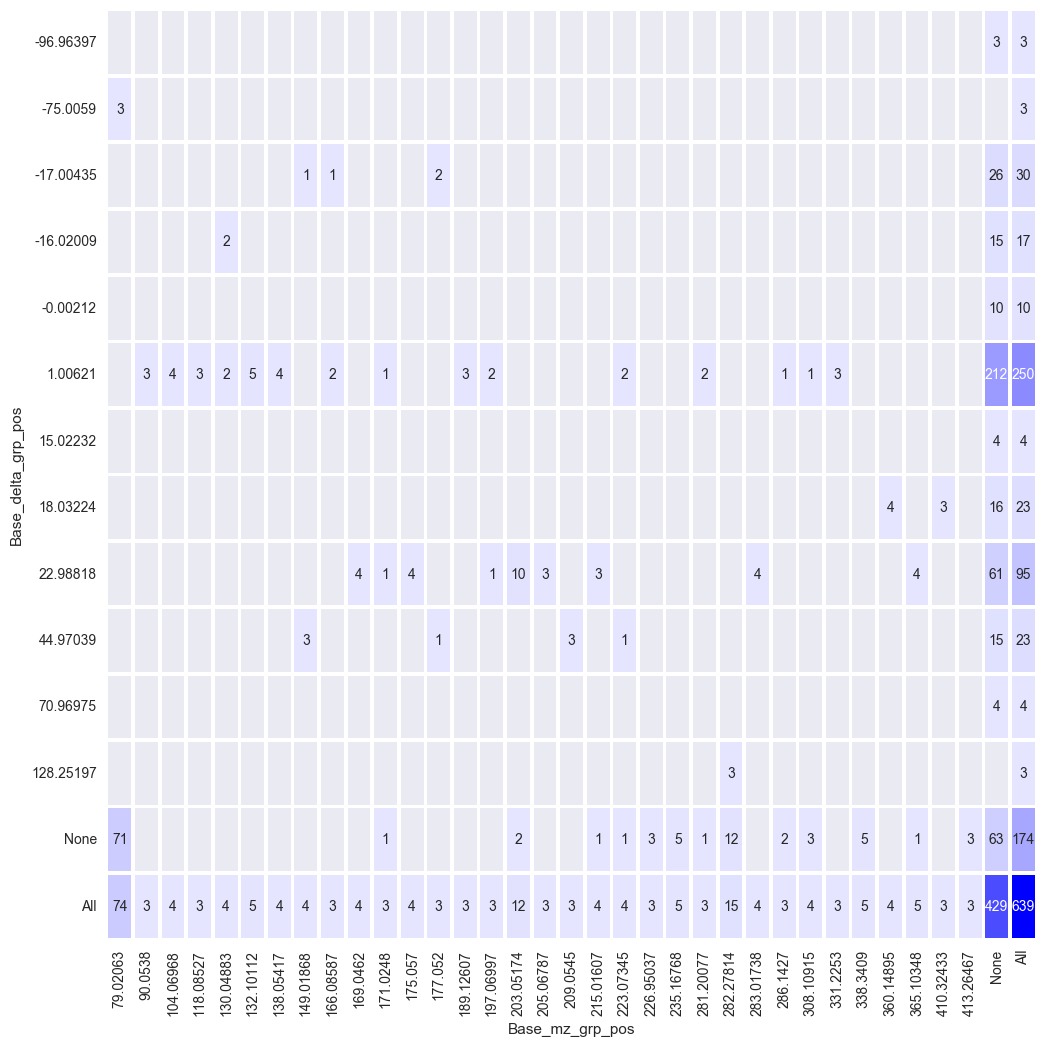

In [22]:
f = tabulate_and_plot(gdf.Base_delta_grp_pos, gdf.Base_mz_grp_pos)
if do_write:figs.append(f)

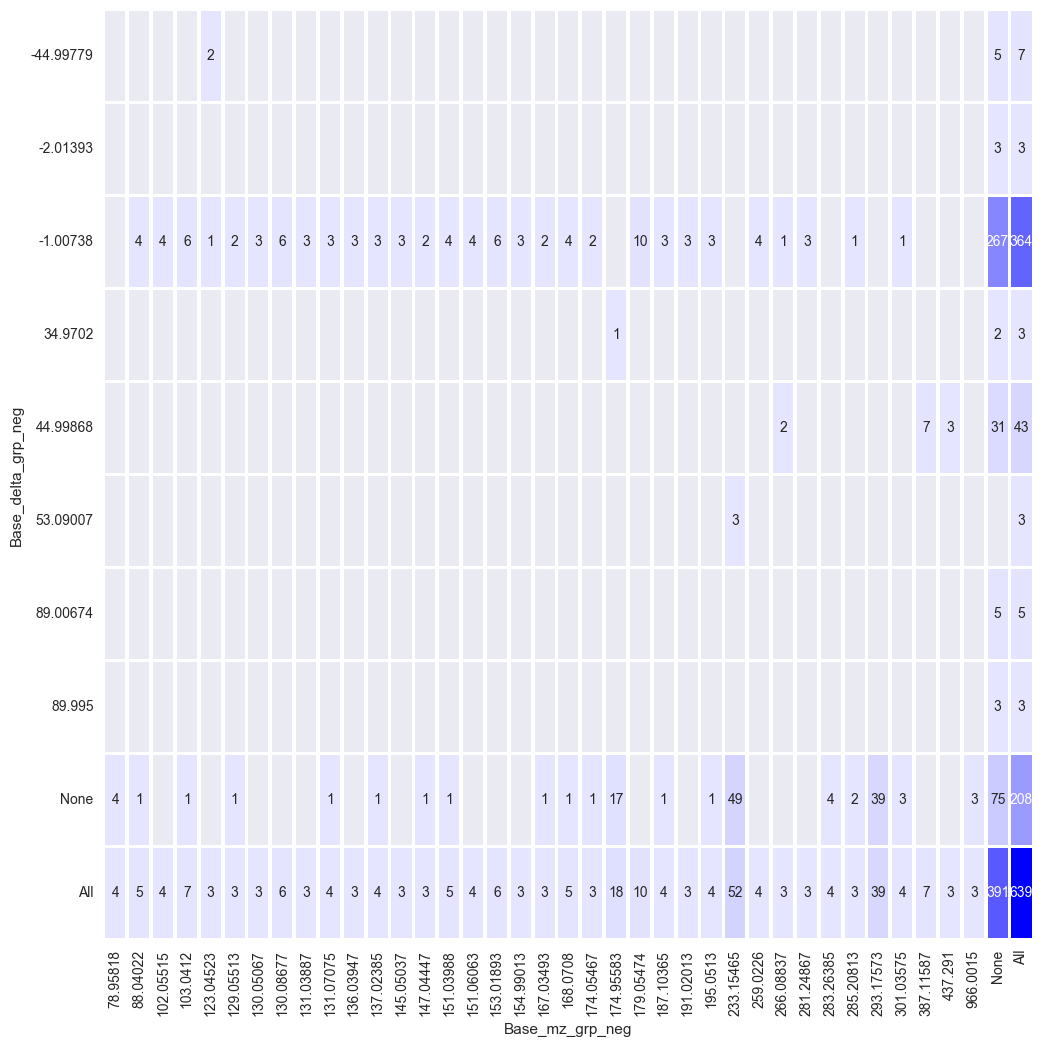

In [23]:
f = tabulate_and_plot(gdf.Base_delta_grp_neg, gdf.Base_mz_grp_neg)
if do_write:figs.append(f)

In [24]:
if do_write:
    pp = PdfPages(smv_path + ' SMV summary plots.pdf')
    for f in figs:
        pp.savefig(f, bbox_inches='tight')
    pp.close()